In [1]:
"""
Author https://github.com/boguss1225
Reference : https://github.com/calmisential/TensorFlow2.0_Image_Classification
"""
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import pandas as pd
import config
from utils.evaluate import eval_model
from utils.prepare_data import get_datasets
from utils.pretrained_models import pretrained_model
import matplotlib.pyplot as plt
import config

2023-01-08 11:27:12.733725: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 11:27:13.687770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-08 11:27:13.687844: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-08 11:27:13.687850: W tensorflow/c

In [2]:
# SELECT GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# SELECT MODEL

available_models=["Xception",
                  "EfficientNetB0", "EfficientNetB1", "EfficientNetB2",
                  "EfficientNetB3", "EfficientNetB4", "EfficientNetB5",
                  "EfficientNetB6", "EfficientNetB7",
                  "EfficientNetV2B0", "EfficientNetV2B1",
                  "EfficientNetV2B2", "EfficientNetV2B3",
                  "EfficientNetV2S", "EfficientNetV2M", "EfficientNetV2L",
                  "VGG16","VGG19",
                  "DenseNet121", "DenseNet169", "DenseNet201",
                  "NASNetLarge","NASNetMobile",
                  "InceptionV3","InceptionResNetV2"
                  ]

def get_model():
    model = pretrained_model(model_name="EfficientNetB0",
                            load_weight=None)

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  metrics=['accuracy', # add more metrics if you want
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            ])
    return model

In [4]:
# GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# LOAD DATA
train_generator, valid_generator, test_generator, \
train_num, valid_num, test_num = get_datasets()

Found 500 images belonging to 5 classes.
Found 125 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


In [6]:
"""
Apply image data augmentation in 'utils.prepare_data.py' manually
"""
config.image_height

128

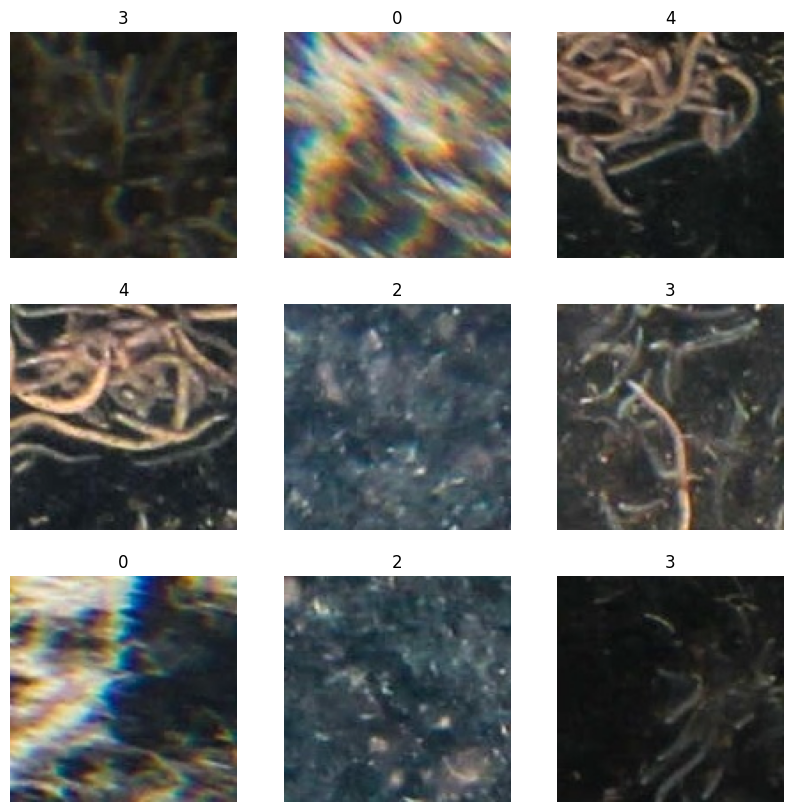

In [7]:
"""
## Visualize the data after augmentaion
Here are the first 9 images in the training dataset. 
Label 0 : "Beggiatoa 1 (thick mat)"
Label 1 : "Beggiatoa 2 (patchy)"
Label 2 : "Beggiatoa 3 (thin film)"
Label 3 : "Worm 1 (Ophryotroca shieldsii - thin colony)"
Label 4 : "Worm 2 (Schistomeringos lovenii - thick worms)"
"""
if config.BATCH_SIZE > 9 :
    range_val = 9
else :
    range_val = config.BATCH_SIZE

plt.figure(figsize=(10, 10))
for i in range(range_val):
    ax = plt.subplot(3, 3, i + 1)
    img, label = train_generator.next()
    plt.imshow(img[0].astype("uint8"))
    plt.title(label[0].argmax())
    plt.axis("off")

In [8]:
"""
Callbacks
"""

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='log')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=config.model_dir+config.model_save_name+".keras",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=50,
    restore_best_weights=True
)

callbacks = [
#     tensorboard, 
    model_checkpoint_callback, 
    early_stop_callback
]

In [9]:
model = get_model()
# tf.keras.utils.plot_model(model, show_shapes=True)

2023-01-08 11:27:25.786797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 11:27:26.258311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8258 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


In [10]:
"""
Train the model
"""
# mkdir for model save path
if not os.path.exists(config.model_dir):
    os.makedirs(config.model_dir)
    
history = model.fit(train_generator,
                    epochs=1000,
                    steps_per_epoch=train_num // config.BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_num // config.BATCH_SIZE,
                    callbacks=callbacks)

Epoch 1/1000


2023-01-08 11:27:39.552997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-08 11:27:42.302167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-01-08 11:27:42.960699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-08 11:27:43.022872: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5b9c0132b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-08 11:27:43.022908: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-01-08 11:27:43.028125: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] dis

3/3 [==============================] - 34s 397ms/step - loss: 1.6107 - accuracy: 0.2070 - auc: 0.4966 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 1s 278ms/step - loss: 1.5806 - accuracy: 0.2604 - auc: 0.5918 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 1s 274ms/step - loss: 1.4946 - accuracy: 0.3226 - auc: 0.7031 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 1s 272ms/step - loss: 1.3480 - accuracy: 0.3952 - auc: 0.7608 - precision: 0.6591 - recall: 0.1559
Epoch 5/1000
3/3 [==============================] - 1s 272ms/step - loss: 1.3222 - accuracy: 0.3280 - auc: 0.7528 - precision: 0.6000 - recall: 0.0726
Epoch 6/1000
3/3 [==============================] - 1s 277ms/step - loss: 1.2518 - accuracy: 0.3871 - auc: 0.7709 - precision: 0.8095 - recall: 0.0457
Epoch 7/1000
3/3 [==============================] - 1s 272ms/step - loss: 1.1914 -

3/3 [==============================] - 1s 247ms/step - loss: 0.4495 - accuracy: 0.8306 - auc: 0.9720 - precision: 0.8425 - recall: 0.8199
Epoch 55/1000
3/3 [==============================] - 1s 248ms/step - loss: 0.5403 - accuracy: 0.8145 - auc: 0.9602 - precision: 0.8255 - recall: 0.8011
Epoch 56/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.3999 - accuracy: 0.8490 - auc: 0.9783 - precision: 0.8613 - recall: 0.8411
Epoch 57/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.5726 - accuracy: 0.7903 - auc: 0.9595 - precision: 0.8039 - recall: 0.7823
Epoch 58/1000
3/3 [==============================] - 1s 246ms/step - loss: 0.5544 - accuracy: 0.7823 - auc: 0.9601 - precision: 0.7921 - recall: 0.7581
Epoch 59/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.4722 - accuracy: 0.8145 - auc: 0.9698 - precision: 0.8283 - recall: 0.8038
Epoch 60/1000
3/3 [==============================] - 1s 255ms/step - loss: 0.5090 - accuracy: 0.7742 -

3/3 [==============================] - 1s 257ms/step - loss: 0.4341 - accuracy: 0.8542 - auc: 0.9729 - precision: 0.8583 - recall: 0.8516
Epoch 108/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.4652 - accuracy: 0.8203 - auc: 0.9716 - precision: 0.8302 - recall: 0.8151
Epoch 109/1000
3/3 [==============================] - 1s 252ms/step - loss: 0.3877 - accuracy: 0.8495 - auc: 0.9786 - precision: 0.8583 - recall: 0.8468
Epoch 110/1000
3/3 [==============================] - 1s 250ms/step - loss: 0.3929 - accuracy: 0.8629 - auc: 0.9759 - precision: 0.8925 - recall: 0.8038
Epoch 111/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.3382 - accuracy: 0.8763 - auc: 0.9821 - precision: 0.8920 - recall: 0.8656
Epoch 112/1000
3/3 [==============================] - 1s 255ms/step - loss: 0.3041 - accuracy: 0.8925 - auc: 0.9867 - precision: 0.8946 - recall: 0.8898
Epoch 113/1000
3/3 [==============================] - 1s 272ms/step - loss: 0.2721 - accuracy: 0.

3/3 [==============================] - 1s 250ms/step - loss: 0.2206 - accuracy: 0.9328 - auc: 0.9913 - precision: 0.9328 - recall: 0.9328
Epoch 161/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.2592 - accuracy: 0.9089 - auc: 0.9890 - precision: 0.9089 - recall: 0.9089
Epoch 162/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.1491 - accuracy: 0.9570 - auc: 0.9968 - precision: 0.9593 - recall: 0.9516
Epoch 163/1000
3/3 [==============================] - 1s 252ms/step - loss: 0.1515 - accuracy: 0.9382 - auc: 0.9972 - precision: 0.9382 - recall: 0.9382
Epoch 164/1000
3/3 [==============================] - 1s 248ms/step - loss: 0.1756 - accuracy: 0.9516 - auc: 0.9924 - precision: 0.9516 - recall: 0.9516
Epoch 165/1000
3/3 [==============================] - 1s 248ms/step - loss: 0.1863 - accuracy: 0.9301 - auc: 0.9932 - precision: 0.9301 - recall: 0.9301
Epoch 166/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.2200 - accuracy: 0.

3/3 [==============================] - 1s 252ms/step - loss: 0.0735 - accuracy: 0.9740 - auc: 0.9975 - precision: 0.9765 - recall: 0.9740
Epoch 214/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.1048 - accuracy: 0.9635 - auc: 0.9969 - precision: 0.9635 - recall: 0.9635
Epoch 215/1000
3/3 [==============================] - 1s 245ms/step - loss: 0.1096 - accuracy: 0.9677 - auc: 0.9984 - precision: 0.9704 - recall: 0.9677
Epoch 216/1000
3/3 [==============================] - 1s 251ms/step - loss: 0.0877 - accuracy: 0.9740 - auc: 0.9976 - precision: 0.9765 - recall: 0.9740
Epoch 217/1000
3/3 [==============================] - 1s 251ms/step - loss: 0.0771 - accuracy: 0.9818 - auc: 0.9991 - precision: 0.9818 - recall: 0.9818
Epoch 218/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.1154 - accuracy: 0.9570 - auc: 0.9980 - precision: 0.9595 - recall: 0.9543
Epoch 219/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.1096 - accuracy: 0.

3/3 [==============================] - 1s 271ms/step - loss: 0.0277 - accuracy: 0.9946 - auc: 0.9999 - precision: 0.9946 - recall: 0.9946
Epoch 267/1000
3/3 [==============================] - 1s 248ms/step - loss: 0.0717 - accuracy: 0.9731 - auc: 0.9994 - precision: 0.9757 - recall: 0.9731
Epoch 268/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.0635 - accuracy: 0.9812 - auc: 0.9979 - precision: 0.9812 - recall: 0.9812
Epoch 269/1000
3/3 [==============================] - 1s 278ms/step - loss: 0.0168 - accuracy: 0.9973 - auc: 1.0000 - precision: 0.9973 - recall: 0.9973
Epoch 270/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.0791 - accuracy: 0.9785 - auc: 0.9977 - precision: 0.9785 - recall: 0.9785
Epoch 271/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.0391 - accuracy: 0.9866 - auc: 0.9998 - precision: 0.9892 - recall: 0.9866
Epoch 272/1000
3/3 [==============================] - 1s 252ms/step - loss: 0.0662 - accuracy: 0.

3/3 [==============================] - 1s 315ms/step - loss: 0.1013 - accuracy: 0.9785 - auc: 0.9960 - precision: 0.9811 - recall: 0.9785


In [11]:
# save the whole model
model.save(config.model_dir+config.model_save_name+".h5")

In [12]:
hist_df = pd.DataFrame(history.history)
with open(config.model_dir+"train_history.csv", mode='w') as f:
    hist_df.to_csv(f)

In [13]:
# Evaluation
eval_model(model)

Found 500 images belonging to 5 classes.
Found 125 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


/home/mirap/.conda/envs/tf2/lib/python3.8/site-packages/keras/utils/generic_utils.py:239: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer

In [18]:
import numpy as np
def test_single_image(img_dir, model):
    img_raw = tf.io.read_file(img_dir)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=config.channels)
    img_tensor = tf.image.resize(img_tensor, [config.image_height, config.image_width])

    img_numpy = img_tensor.numpy()
    img_numpy = (np.expand_dims(img_numpy, 0))
    img_tensor = tf.convert_to_tensor(img_numpy, tf.float32)

#     img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(tf.image.resize(img_tensor,[config.image_width,config.image_height]))

    
    
    # 'if not sure go to background' implementation
    precision_threshold = 0.5
    probability = np.max(prob)
    if np.max(prob) < precision_threshold :
        classification = 5
    else :
        classification = np.argmax(prob)
        
    return classification, probability

In [19]:
# detect samples
last_model = model
print(config.test_image_path)
classification_result, probability = test_single_image(config.test_image_path, last_model)
print("class : ",classification_result+1,"of",probability,"%")

/home/mirap/0_DATABASE/IMAS_Salmon/6_Salmon_Yolo_Balanced/test/1/untitled-337_1413_2855_1.jpg
class :  1 of 0.9983419 %


In [20]:
# detect samples
best_model = tf.keras.models.load_model(config.model_dir+config.model_save_name+".h5")
print(config.test_image_path)
classification_result, probability = test_single_image(config.test_image_path, best_model)
print("class : ",classification_result+1,"of",probability,"%")

/home/mirap/0_DATABASE/IMAS_Salmon/6_Salmon_Yolo_Balanced/test/1/untitled-337_1413_2855_1.jpg
class :  1 of 0.9983419 %


In [17]:
# Evaluation
eval_model(best_model)

Found 500 images belonging to 5 classes.
Found 125 images belonging to 5 classes.
Found 125 images belonging to 5 classes.


OverflowError: cannot convert float infinity to integer

125